# Automated Machine Learning
_**Orange Juice Sales Forecasting**_


<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

## Introduction
In this example, we use AutoML to train, select, and operationalize a time-series forecasting model for multiple time-series.

Make sure you have executed the [configuration notebook](../../../configuration.ipynb) before running this notebook.

The examples in the follow code samples use the University of Chicago's Dominick's Finer Foods dataset to forecast orange juice sales. Dominick's was a grocery chain in the Chicago metropolitan area.

## Setup

In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig

In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2020-07-20 10:34:42.306071


In [3]:
#Version
import azureml.core
print("Version Azure ML :", azureml.core.VERSION)


Version Azure ML : 1.9.0


In [4]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'Exemple4-AutoMLForecastSales'

experiment = Experiment(ws, experiment_name)

output = {}
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Workspace,workshopAML2020
SKU,Enterprise
Resource Group,workshopAML2020-rg
Location,westeurope
Run History Name,Exemple4-AutoMLForecastSales


## Compute
You will need to create a [compute target](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.
#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [5]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = "oj-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Data
You are now ready to load the historical orange juice sales data. We will load the CSV file into a plain pandas DataFrame; the time column in the CSV is called _WeekStarting_, so it will be specially parsed into the datetime type.

In [6]:
time_column_name = 'WeekStarting'
data = pd.read_csv("dominicks_OJ.csv", parse_dates=[time_column_name])
data.head()

,WeekStarting,Store,Brand,Quantity,logQuantity,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,1990-06-14,2,dominicks,10560,9.264829,1,1.59,0.232865,0.248935,10.553205,0.463887,0.103953,0.114280,0.303585,2.110122,1.142857,1.927280,0.376927
1,1990-06-14,2,minute.maid,4480,8.407378,0,3.17,0.232865,0.248935,10.553205,0.463887,0.103953,0.114280,0.303585,2.110122,1.142857,1.927280,0.376927
2,1990-06-14,2,tropicana,8256,9.018695,0,3.87,0.232865,0.248935,10.553205,0.463887,0.103953,0.114280,0.303585,2.110122,1.142857,1.927280,0.376927
3,1990-06-14,5,dominicks,1792,7.491088,1,1.59,0.117368,0.321226,10.922371,0.535883,0.103092,0.053875,0.410568,3.801998,0.681818,1.600573,0.736307
4,1990-06-14,5,minute.maid,4224,8.348538,0,2.99,0.117368,0.321226,10.922371,0.535883,0.103092,0.053875,0.410568,3.801998,0.681818,1.600573,0.736307


Each row in the DataFrame holds a quantity of weekly sales for an OJ brand at a single store. The data also includes the sales price, a flag indicating if the OJ brand was advertised in the store that week, and some customer demographic information based on the store location. For historical reasons, the data also include the logarithm of the sales quantity. The Dominick's grocery data is commonly used to illustrate econometric modeling techniques where logarithms of quantities are generally preferred.    

The task is now to build a time-series model for the _Quantity_ column. It is important to note that this dataset is comprised of many individual time-series - one for each unique combination of _Store_ and _Brand_. To distinguish the individual time-series, we thus define the **grain** - the columns whose values determine the boundaries between time-series: 

In [7]:
grain_column_names = ['Store', 'Brand']
nseries = data.groupby(grain_column_names).ngroups
print('Data contains {0} individual time-series.'.format(nseries))

Data contains 249 individual time-series.


For demonstration purposes, we extract sales time-series for just a few of the stores:

In [8]:
use_stores = [2, 5, 8]
data_subset = data[data.Store.isin(use_stores)]
nseries = data_subset.groupby(grain_column_names).ngroups
print('Data subset contains {0} individual time-series.'.format(nseries))

Data subset contains 9 individual time-series.


### Data Splitting
We now split the data into a training and a testing set for later forecast evaluation. The test set will contain the final 20 weeks of observed sales for each time-series. The splits should be stratified by series, so we use a group-by statement on the grain columns.

In [9]:
n_test_periods = 20

def split_last_n_by_grain(df, n):
    """Group df by grain and split on last n rows for each group."""
    df_grouped = (df.sort_values(time_column_name) # Sort by ascending time
                  .groupby(grain_column_names, group_keys=False))
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail

train, test = split_last_n_by_grain(data_subset, n_test_periods)

### Upload data to datastore
The [Machine Learning service workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace), is paired with the storage account, which contains the default data store. We will use it to upload the train and test data and create [tabular datasets](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) for training and testing. A tabular dataset defines a series of lazily-evaluated, immutable operations to load data from the data source into tabular representation.

In [10]:
train.to_csv (r'./dominicks_OJ_train.csv', index = None, header=True)
test.to_csv (r'./dominicks_OJ_test.csv', index = None, header=True)

In [11]:
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./dominicks_OJ_train.csv', './dominicks_OJ_test.csv'], target_path = 'dataset/', overwrite = True,show_progress = True)

Uploading an estimated of 2 files
Uploading ./dominicks_OJ_test.csv
Uploading ./dominicks_OJ_train.csv
Uploaded ./dominicks_OJ_test.csv, 1 files out of an estimated total of 2
Uploaded ./dominicks_OJ_train.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_538a856cf86144f28cb67793f55858f9

### Create dataset for training

In [12]:
from azureml.core.dataset import Dataset
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('dataset/dominicks_OJ_train.csv'))

In [13]:
train_dataset.to_pandas_dataframe().tail()

,WeekStarting,Store,Brand,Quantity,logQuantity,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
847,1992-04-09,8,tropicana,16192,9.692273,0,2.50,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016
848,1992-04-16,8,tropicana,6528,8.783856,0,2.89,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016
849,1992-04-23,8,tropicana,8320,9.026418,0,2.89,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016
850,1992-04-30,8,tropicana,30784,10.334750,1,2.16,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016
851,1992-05-07,8,tropicana,18048,9.800790,0,2.89,0.252394,0.095173,10.59701,0.054227,0.13175,0.035243,0.283075,2.636333,1.5,2.905384,0.641016


## Modeling

For forecasting tasks, AutoML uses pre-processing and estimation steps that are specific to time-series. AutoML will undertake the following pre-processing steps:
* Detect time-series sample frequency (e.g. hourly, daily, weekly) and create new records for absent time points to make the series regular. A regular time series has a well-defined frequency and has a value at every sample point in a contiguous time span 
* Impute missing values in the target (via forward-fill) and feature columns (using median column values) 
* Create grain-based features to enable fixed effects across different series
* Create time-based features to assist in learning seasonal patterns
* Encode categorical variables to numeric quantities

In this notebook, AutoML will train a single, regression-type model across **all** time-series in a given training set. This allows the model to generalize across related series. If you're looking for training multiple models for different time-series, please check out the forecasting grouping notebook. 

You are almost ready to start an AutoML training job. First, we need to separate the target column from the rest of the DataFrame: 

In [14]:
target_column_name = 'Quantity'

## Customization

The featurization customization in forecasting is an advanced feature in AutoML which allows our customers to change the default forecasting featurization behaviors and column types through `FeaturizationConfig`. The supported scenarios include,
1. Column purposes update: Override feature type for the specified column. Currently supports DateTime, Categorical and Numeric. This customization can be used in the scenario that the type of the column cannot correctly reflect its purpose. Some numerical columns, for instance, can be treated as Categorical columns which need to be converted to categorical while some can be treated as epoch timestamp which need to be converted to datetime. To tell our SDK to correctly preprocess these columns, a configuration need to be add with the columns and their desired types.
2. Transformer parameters update: Currently supports parameter change for Imputer only. User can customize imputation methods, the supported methods are constant for target data and mean, median, most frequent and constant for training data. This customization can be used for the scenario that our customers know which imputation methods fit best to the input data. For instance, some datasets use NaN to represent 0 which the correct behavior should impute all the missing value with 0. To achieve this behavior, these columns need to be configured as constant imputation with `fill_value` 0.
3. Drop columns: Columns to drop from being featurized. These usually are the columns which are leaky or the columns contain no useful data.

This step requires an Enterprise workspace to gain access to this feature. To learn more about creating an Enterprise workspace or upgrading to an Enterprise workspace from the Azure portal, please visit our [Workspace page.](https://docs.microsoft.com/azure/machine-learning/service/concept-workspace#upgrade)

In [15]:
featurization_config = FeaturizationConfig()
featurization_config.drop_columns = ['logQuantity']  # 'logQuantity' is a leaky feature, so we remove it.
# Force the CPWVOL5 feature to be numeric type.
featurization_config.add_column_purpose('CPWVOL5', 'Numeric')
# Fill missing values in the target column, Quantity, with zeros.
featurization_config.add_transformer_params('Imputer', ['Quantity'], {"strategy": "constant", "fill_value": 0})
# Fill missing values in the INCOME column with median value.
featurization_config.add_transformer_params('Imputer', ['INCOME'], {"strategy": "median"})

## Train

The [AutoMLConfig](https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py) object defines the settings and data for an AutoML training job. Here, we set necessary inputs like the task type, the number of AutoML iterations to try, the training data, and cross-validation parameters.

For forecasting tasks, there are some additional parameters that can be set: the name of the column holding the date/time, the grain column names, and the maximum forecast horizon. A time column is required for forecasting, while the grain is optional. If grain columns are not given, AutoML assumes that the whole dataset is a single time-series. We also pass a list of columns to drop prior to modeling. The _logQuantity_ column is completely correlated with the target quantity, so it must be removed to prevent a target leak.

The forecast horizon is given in units of the time-series frequency; for instance, the OJ series frequency is weekly, so a horizon of 20 means that a trained model will estimate sales up to 20 weeks beyond the latest date in the training data for each series. In this example, we set the maximum horizon to the number of samples per series in the test set (n_test_periods). Generally, the value of this parameter will be dictated by business needs. For example, a demand planning application that estimates the next month of sales should set the horizon according to suitable planning time-scales. Please see the [energy_demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand) for more discussion of forecast horizon.

We note here that AutoML can sweep over two types of time-series models:
* Models that are trained for each series such as ARIMA and Facebook's Prophet. Note that these models are only available for [Enterprise Edition Workspaces](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace#upgrade).
* Models trained across multiple time-series using a regression approach.

In the first case, AutoML loops over all time-series in your dataset and trains one model (e.g. AutoArima or Prophet, as the case may be) for each series. This can result in long runtimes to train these models if there are a lot of series in the data. One way to mitigate this problem is to fit models for different series in parallel if you have multiple compute cores available. To enable this behavior, set the `max_cores_per_iteration` parameter in your AutoMLConfig as shown in the example in the next cell. 


Finally, a note about the cross-validation (CV) procedure for time-series data. AutoML uses out-of-sample error estimates to select a best pipeline/model, so it is important that the CV fold splitting is done correctly. Time-series can violate the basic statistical assumptions of the canonical K-Fold CV strategy, so AutoML implements a [rolling origin validation](https://robjhyndman.com/hyndsight/tscv/) procedure to create CV folds for time-series data. To use this procedure, you just need to specify the desired number of CV folds in the AutoMLConfig object. It is also possible to bypass CV and use your own validation set by setting the *validation_data* parameter of AutoMLConfig.

Here is a summary of AutoMLConfig parameters used for training the OJ model:

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**experiment_timeout_hours**|Experimentation timeout in hours.|
|**enable_early_stopping**|If early stopping is on, training will stop when the primary metric is no longer improving.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross-validation folds to use for model/pipeline selection|
|**enable_voting_ensemble**|Allow AutoML to create a Voting ensemble of the best performing models|
|**enable_stack_ensemble**|Allow AutoML to create a Stack ensemble of the best performing models|
|**debug_log**|Log file path for writing debugging information|
|**time_column_name**|Name of the datetime column in the input data|
|**grain_column_names**|Name(s) of the columns defining individual series in the input data|
|**max_horizon**|Maximum desired forecast horizon in units of time-series frequency|
|**featurization**| 'auto' / 'off' / FeaturizationConfig Indicator for whether featurization step should be done automatically or not, or whether customized featurization should be used. Setting this enables AutoML to perform featurization on the input to handle *missing data*, and to perform some common *feature extraction*.|
|**max_cores_per_iteration**|Maximum number of cores to utilize per iteration. A value of -1 indicates all available cores should be used.|

In [16]:
time_series_settings = {
    'time_column_name': time_column_name,
    'time_series_id_column_names': grain_column_names,
    'forecast_horizon': n_test_periods
}

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_oj_sales_errors.log',
                             primary_metric='normalized_mean_absolute_error',
                             experiment_timeout_hours=0.25,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             featurization=featurization_config,
                             n_cross_validations=3,
                             verbosity=logging.INFO,
                             max_cores_per_iteration=-1,
                             **time_series_settings)

You can now submit a new training run. Depending on the data and number of iterations this operation may take several minutes.
Information from each iteration will be printed to the console.

In [17]:
remote_run = experiment.submit(automl_config, show_output=True)
remote_run

WARNING - Using different time series parameters in AutoML configs for forecasting tasks will be deprecated, please use ForecastingParameters class instead.


Running on remote or ADB.
Running on remote compute: oj-cluster
Parent Run ID: AutoML_627c0371-0d6a-4639-8d6f-f268224fc74f

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

**************************

WARNING - Using different time series parameters in AutoML configs for forecasting tasks will be deprecated, please use ForecastingParameters class instead.
WARNING - Forecasting parameter grain_column_names will be deprecated in the future, please use time_series_id_column_names instead.
WARNING - Forecasting parameter max_horizon will be deprecated in the future, please use forecast_horizon instead.
WARNING - Forecasting parameter country_or_region will be deprecated in the future, please use holiday_country instead.


Something went wrong while printing the experiment progress but the run is still executing on the compute target. 
Please check portal for updated status: https://ml.azure.com/experiments/Exemple4-AutoMLForecastSales/runs/AutoML_627c0371-0d6a-4639-8d6f-f268224fc74f?wsid=/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourcegroups/workshopAML2020-rg/workspaces/workshopAML2020


Experiment,Id,Type,Status,Details Page,Docs Page
Exemple4-AutoMLForecastSales,AutoML_627c0371-0d6a-4639-8d6f-f268224fc74f,automl,Running,Link to Azure Machine Learning studio,Link to Documentation


In [18]:
remote_run.wait_for_completion()

{'runId': 'AutoML_627c0371-0d6a-4639-8d6f-f268224fc74f',
 'target': 'oj-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-07-20T10:40:05.268875Z',
 'endTimeUtc': '2020-07-20T10:57:28.69994Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_mean_absolute_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'oj-cluster',
  'RawAMLSettingsString': "{'path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/instance/code/WorkshopAML2020', 'name': 'Exemple4-AutoMLForecastSales', 'subscription_id': '70b8f39e-8863-49f7-b6ba-34a80799550c', 'resource_group': 'workshopAML2020-rg', 'workspace_name': 'workshopAML2020', 'region': 'westeurope', 'compute_target': 'oj-cluster', 'spark_service': None, 'azure_service': 'Microsoft.AzureNotebookVM', '_local_managed_run_id': None, 'iterations': 1000, 'primary_metric': 'normalized_mean_absolute_error', 'task_typ

### Retrieve the Best Model
Each run within an Experiment stores serialized (i.e. pickled) pipelines from the AutoML iterations. We can now retrieve the pipeline with the best performance on the validation dataset:

In [19]:
best_run, fitted_model = remote_run.get_output()
print(fitted_model.steps)
model_name = best_run.properties['model_name']

WARNING - Using different time series parameters in AutoML configs for forecasting tasks will be deprecated, please use ForecastingParameters class instead.
WARNING - Forecasting parameter grain_column_names will be deprecated in the future, please use time_series_id_column_names instead.
WARNING - Forecasting parameter max_horizon will be deprecated in the future, please use forecast_horizon instead.
WARNING - Forecasting parameter country_or_region will be deprecated in the future, please use holiday_country instead.
WARNING - Using different time series parameters in AutoML configs for forecasting tasks will be deprecated, please use ForecastingParameters class instead.
WARNING - Forecasting parameter grain_column_names will be deprecated in the future, please use time_series_id_column_names instead.
WARNING - Forecasting parameter max_horizon will be deprecated in the future, please use forecast_horizon instead.
WARNING - Forecasting parameter country_or_region will be deprecated i

[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('3', Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=0.6,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_s...toarima', <azureml.automl.runtime.shared.forecasting_models.AutoArima object at 0x7f106a1ad668>)]))],
               flatten_transform=None, weights=[0.2, 0.3, 0.2, 0.2, 0.1]))]


## Transparency

View updated featurization summary

In [20]:
custom_featurizer = fitted_model.named_steps['timeseriestransformer']

In [21]:
custom_featurizer.get_featurization_summary()

[{'RawFeatureName': 'Advert',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'Price',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'Age60',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'COLLEGE',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'INCOME',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'Hincome150',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer',

# Forecasting

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. First, we remove the target values from the test set:

In [22]:
X_test = test
y_test = X_test.pop(target_column_name).values

In [23]:
X_test.head()

,WeekStarting,Store,Brand,logQuantity,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
24192,1992-05-21,2,dominicks,9.18,0,1.69,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
24441,1992-05-28,2,dominicks,10.73,0,1.69,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
24675,1992-06-04,2,dominicks,9.95,0,1.74,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
24909,1992-06-11,2,dominicks,8.79,0,2.09,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38
25152,1992-06-18,2,dominicks,8.52,0,2.05,0.23,0.25,10.55,0.46,0.10,0.11,0.30,2.11,1.14,1.93,0.38


To produce predictions on the test set, we need to know the feature values at all dates in the test set. This requirement is somewhat reasonable for the OJ sales data since the features mainly consist of price, which is usually set in advance, and customer demographics which are approximately constant for each store over the 20 week forecast horizon in the testing data.

In [24]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

If you are used to scikit pipelines, perhaps you expected `predict(X_test)`. However, forecasting requires a more general interface that also supplies the past target `y` values. Please use `forecast(X,y)` as `predict(X)` is reserved for internal purposes on forecasting models.

The [forecast function notebook](../forecasting-forecast-function/auto-ml-forecasting-function.ipynb).

# Evaluate

To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE). 

It is a good practice to always align the output explicitly to the input, as the count and order of the rows may have changed during transformations that span multiple rows.

In [25]:
from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

[Test data scores]

explained_variance:   0.266
root_mean_squared_error:   17705.538
normalized_mean_absolute_error:   0.076
normalized_median_absolute_error:   0.029
normalized_root_mean_squared_log_error:   0.159
median_absolute_error:   3868.026
mean_absolute_error:   10001.847
normalized_root_mean_squared_error:   0.134
root_mean_squared_log_error:   0.722
mean_absolute_percentage_error:   76.252
r2_score:   0.259
spearman_correlation:   0.654


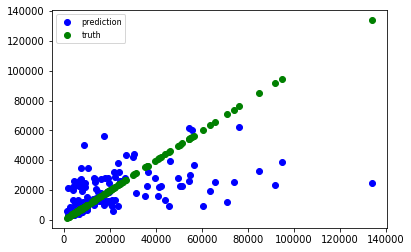

In [26]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

# Operationalize

_Operationalization_ means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.

In [27]:
description = 'AutoML OJ forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

WARNING - Using different time series parameters in AutoML configs for forecasting tasks will be deprecated, please use ForecastingParameters class instead.
WARNING - Forecasting parameter grain_column_names will be deprecated in the future, please use time_series_id_column_names instead.
WARNING - Forecasting parameter max_horizon will be deprecated in the future, please use forecast_horizon instead.
WARNING - Forecasting parameter country_or_region will be deprecated in the future, please use holiday_country instead.
WARNING - Using different time series parameters in AutoML configs for forecasting tasks will be deprecated, please use ForecastingParameters class instead.
WARNING - Forecasting parameter grain_column_names will be deprecated in the future, please use time_series_id_column_names instead.
WARNING - Forecasting parameter max_horizon will be deprecated in the future, please use forecast_horizon instead.
WARNING - Forecasting parameter country_or_region will be deprecated i

AutoML627c037107


### Develop the scoring script

For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.

In [28]:
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

### Deploy the model as a Web Service on Azure Container Instance

In [29]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': "automl-forecasting"},
                                               description = "Automl forecasting sample service")

aci_service_name = 'automl-oj-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-oj-forecast-01
Running................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [33]:
aci_service.get_logs()

'2020-07-20T11:12:37,031011098+00:00 - gunicorn/run \n2020-07-20T11:12:37,032131104+00:00 - iot-server/run \n2020-07-20T11:12:37,034090513+00:00 - rsyslog/run \n2020-07-20T11:12:37,041545048+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_5eb6df75930b264b533a5ee769ea880a/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_5eb6df75930b264b533a5ee769ea880a/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_5eb6df75930b264b533a5ee769ea880a/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_5eb6df75930b264b533a5ee769ea880a/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_5eb6df75930b264b533a5ee769ea880a/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

### Call the service

In [34]:
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [35]:
y_fcst_all.head()

,Brand,Store,WeekStarting,forecast
0,dominicks,2,1992-05-21,9339.26
1,dominicks,2,1992-05-28,9449.13
2,dominicks,2,1992-06-04,9178.13
3,dominicks,2,1992-06-11,4048.57
4,dominicks,2,1992-06-18,4317.94


### Delete the web service if desired

In [36]:
#serv = Webservice(ws, 'automl-oj-forecast-01')
#serv.delete()     # don't do it accidentally

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">